# CS146 Project 2: Discrete and multi-level models


## Data

The integer values below are the recorded kelp counts. There are some `nan` values where we have missing data. The missing data show up as white squares in the plot below.

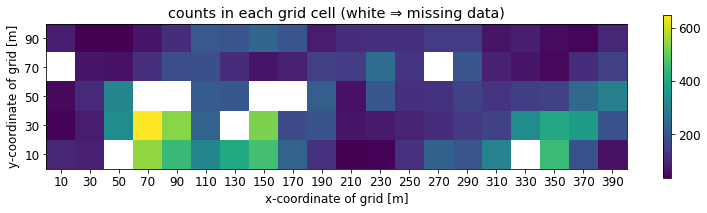

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import nan
import math

plt.rcParams.update({'font.size': 12})

grid_count_x = 20  # number of grid cells in the x and y directions
grid_count_y = 5
grid_cell_width = 20  # number of meters per grid cell side
area_per_cell = grid_cell_width ** 2  # each grid cell has an area of (20 m)² = 400 m²

grid_x = (np.arange(grid_count_x) + 0.5) * grid_cell_width
grid_y = (np.arange(grid_count_y) + 0.5) * grid_cell_width

data = np.array([
    [101,  92, nan, 550, 450, 318, 408, 465, 232, 123,  39,  41, 123, 226, 198, 307, nan, 454, 191,  63],
    [ 43,  86, 334, 649, 540, 231, nan, 529, 179, 193,  74,  80,  94, 113, 138, 155, 331, 405, 372, 191],
    [ 51, 110, 314, nan, nan, 215, 205, nan, nan, 221,  67, 203, 120, 125, 158, 129, 149, 156, 245, 304],
    [nan,  74,  66, 119, 184, 186, 115,  71,  89, 151, 145, 255, 127, nan, 199,  92,  74,  49, 116, 153],
    [ 87,  36,  37,  70, 116, 207, 201, 235, 199,  84, 117, 118, 121, 144, 146,  69,  87,  54,  44, 101]])

plt.figure(figsize=(13, 3))
plt.title('counts in each grid cell (white ⇒ missing data)')
plt.xlabel('x-coordinate of grid [m]')
plt.ylabel('y-coordinate of grid [m]')
plt.imshow(data, origin='lower')
plt.xticks(np.arange(data.shape[1]), np.array(grid_x, dtype=int))
plt.yticks(np.arange(data.shape[0]), np.array(grid_y, dtype=int))
plt.colorbar()
plt.show()

In [2]:
#clean the data to get rid of the nan values
import math
data2=[]
for i in range(len(data)):
    for j in range(len(data[i])):
        if math.isnan(data[i][j])!=True: 
            data2.append(data[i][j])


# Strategy

To estimate the value of the missing cells, we would use a simple complete pooling model and a more complex partial pooling hierarchical model. Complete pooling means that each data point is treated as equal : we assume each grid square is identical and is going to have the same distribution of kelp. Thus, for this model we only need a single prior, reflecting that the same one parameter is governing the distribution of kelp in all grid squares since there is no variation between the squares. Since we use one parameter to estimate the number of kelp in each square, there might be a lot of cases where our estimate does not match each square's kelp count, leading to underfitting. Partial pooling, on the other hand, finds a balance between overfitting and underfitting by creating a different parameter for each grid square at the same time as estimating the variation of all grid squares. It means that the model uses the information from different grid squares to inform its estimation for another grid square, while keeping the clusters less dependent compared to a complete pooling model.


The next step is to choose the priors (and hyperpriors for the partial pooling model) for the parameters we have. The only information we get is that there should be 0-2 kelp plants per square meter, so from 0 to 800 plants for each grid square. We will incorporate this information in our prior distribution, placing most of the probability density on the range 0-800, while still leaving the possibility of the number of kelp plants being more than 800. 


After we build our models, we will check if the sampling algorithm worked correctly by looking at the divergences, rank plots, r_hat values, and effective sample sizes. If there are problems, we will try to address them by increasing the number if tuning steps, increasing the acceptance rate, or performing non-centralized reparameterization. Non-centralized reparameterization simply means expressing a variable in a different numerical way but keeping it mathematically the same. This is useful because it helps the model explore the posterior by getting rid of the steep regions of the posterior distribution which are hard to explore. 


When we have our 2 models ready, we will then look at the prior and prior predictive distributions to make sure the model generates values for our parameters within reasonable ranges. We will then also explore and interpret posteriors and posterior predictive distributions to see again if the model generates reasonable ranges for the parameters. 

Lastly, we will use the posteriors of the model to generate predictions for the number of kelp plants in missing grid squares and compare them to see which model makes better predictions.

# Models and Interpretations

In [3]:
#import necessary libraries
import arviz as az
import pandas as pd
import pymc as pm
import scipy.stats as sts
from scipy.special import expit as logistic
from scipy.special import expit as invlogit

**Complete Pooling**

For the complete pooling model below, I used a Normal distribution for l parameter, and then transformed it onto the range of positive real numbers using the inverse of the log-link function. This is necessary since the lambda parameter for the Poisson distribution should be greater than or equal to 0. I chose the normal prior, as well as mu and sigma parameters for the Normal prior by running the model with different combinations of mu and sigma parameters (and different priors) and looked at the prior and prior predictive distributions (discussed further) to choose the model that generates the most reasonable ranges for the lambda parameter and C. The model you see below was the best option. Another reason for using a Normal prior was to put the most probability density between 0 and 800, yet still leave the possibility of it being more than 800 kelp plants in a grid square. We can clearly see that the model has a complete pooling structure because we draw lambda parameters for different grid squares from the same distribution, assuming all grid squares are the same.

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
l,5.196,0.008,5.180,5.209,0.000,0.00,657.0,1339.0,1.0
l_trans,180.476,1.436,177.597,182.962,0.056,0.04,657.0,1339.0,1.0


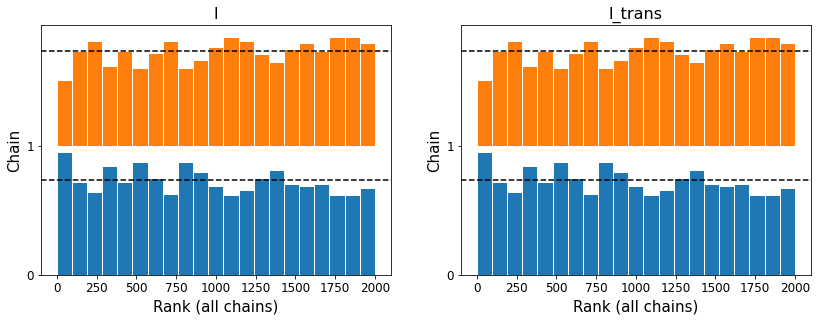

In [4]:
#complete pooling model 
with pm.Model() as model:
#prior
    l=pm.Normal('l',mu=5, sigma=0.7)
    l_trans = pm.Deterministic('l_trans',pm.math.exp(l))
#likelihood
    C=pm.Poisson('C', mu=l_trans , observed = data2)

# Generate posterior samples
with model:
    inference_complete= pm.sample()
    display(az.summary(inference_complete))
    az.plot_rank(inference_complete)


We can see that the r_hat values are below 1.01, which means we have no reason to think that the sampler worked poorly. This value is supposed to indicate how well the sampler converges, with values below 1.01 implying it did so well. Looking at the effective sample size columns we can see that they are more than 10% of the sample size, which also tells us the sampler probably worked well. Lastly, rank plots show us that the 2 chains are very similar and there are no skews in both parameters, which means the sampler explored all posterior and did not get stuck.

In [5]:
#generate prior predictive and posterior predictive samples
with model: 
    inf_prior_pred = pm.sample_prior_predictive()
    inf_post_pred = pm.sample_posterior_predictive(inference_complete, extend_inferencedata=True)

In [6]:
inference_complete

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

In [7]:
inf_prior_pred

Inference data with groups:
	> prior
	> prior_predictive
	> observed_data

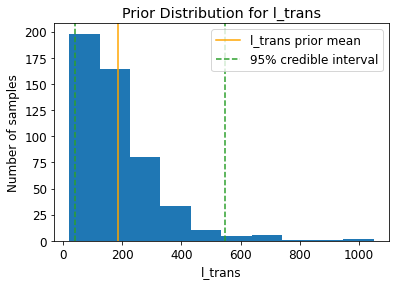

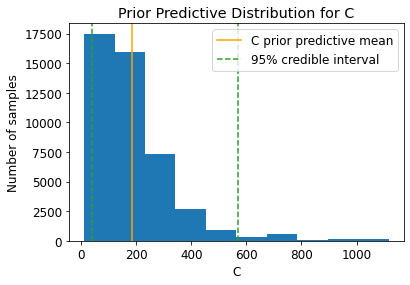

In [8]:
#prior l_trans
plt.hist(inf_prior_pred.prior.l_trans.values.flatten())
plt.title('Prior Distribution for l_trans')
plt.xlabel('l_trans')
plt.ylabel('Number of samples')
plt.axvline(np.mean(inf_prior_pred.prior.l_trans.values.flatten()), color='orange',label='l_trans prior mean')
plt.axvline(np.quantile(inf_prior_pred.prior.l_trans.values.flatten(), 0.025), color='C2', linestyle='--',label='95% credible interval')
plt.axvline(np.quantile(inf_prior_pred.prior.l_trans.values.flatten(), 0.975), color='C2', linestyle='--')
plt.legend()
plt.show()

#prior predictive C
plt.hist(inf_prior_pred.prior_predictive.C.values.flatten())
plt.title('Prior Predictive Distribution for C')
plt.xlabel('C')
plt.ylabel('Number of samples')
plt.axvline(np.mean(inf_prior_pred.prior_predictive.C.values.flatten()), color='orange',label='C prior predictive mean')
plt.axvline(np.quantile(inf_prior_pred.prior_predictive.C.values.flatten(), 0.025), color='C2', linestyle='--',label='95% credible interval')
plt.axvline(np.quantile(inf_prior_pred.prior_predictive.C.values.flatten(), 0.975), color='C2', linestyle='--')
plt.legend()
plt.show()

From the prior and prior predictive plots above we can see that the range for the lambda parameter and C variable are very reasonable given the information we were provided : the model generates values mostly between 0 and 800 (green lines show a 95% credible interval within 0-800 range to support this claim). These are the plots that I looked at to tune the parameteres of the model so that it reflects our knowledge about the data.

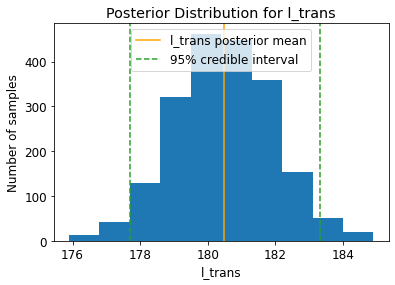

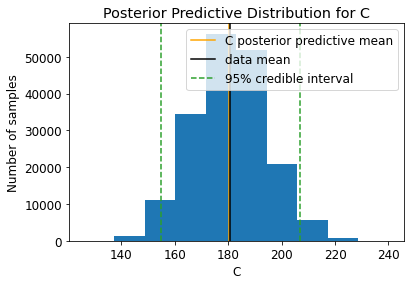

95% credible interval :  [177.6879504359323, 183.3248998551647]
Posterior predictive mean : 180.45174725274725
Data mean : 180.52747252747253


In [9]:
#posterior l_trans
plt.hist(inference_complete.posterior.l_trans.values.flatten())
plt.title('Posterior Distribution for l_trans')
plt.xlabel('l_trans')
plt.ylabel('Number of samples')
plt.axvline(np.mean(inference_complete.posterior.l_trans.values.flatten()), color='orange',label='l_trans posterior mean')
plt.axvline(np.quantile(inference_complete.posterior.l_trans.values.flatten(), 0.025), color='C2', linestyle='--',label='95% credible interval')
plt.axvline(np.quantile(inference_complete.posterior.l_trans.values.flatten(), 0.975), color='C2', linestyle='--')
plt.legend()
plt.show()

#posterior predictive C
plt.hist(inference_complete.posterior_predictive.C.values.flatten())
plt.title('Posterior Predictive Distribution for C')
plt.xlabel('C')
plt.ylabel('Number of samples')
plt.axvline(np.mean(inference_complete.posterior_predictive.C.values.flatten()), color='orange',label='C posterior predictive mean')
plt.axvline(np.mean(data2), color='black',label='data mean')
plt.axvline(np.quantile(inference_complete.posterior_predictive.C.values.flatten(), 0.025), color='C2', linestyle='--',label='95% credible interval')
plt.axvline(np.quantile(inference_complete.posterior_predictive.C.values.flatten(), 0.975), color='C2', linestyle='--')
plt.legend()
plt.show()

print('95% credible interval : ', [np.quantile(inference_complete.posterior.l_trans.values.flatten(), 0.025),np.quantile(inference_complete.posterior.l_trans.values.flatten(), 0.975)])
print('Posterior predictive mean :', np.mean(inference_complete.posterior_predictive.C.values.flatten()))
print('Data mean :', np.mean(data2))

Looking at the posterior plot for the lambda parameter with a 95% credible interval, we can see that the model tells us that the true value of the lambda parameter lies between 177.95 and 183.19. Posterior predictive check lets us see what is the distribution of the number of kelp plants in each grid square is, according to the model. To preliminary evaluate model performance, I plotted and computed the true mean of the data and the mean of the posterior predictive distribution to see how well it matched. It turns out model's mean is almost the same as the data mean (black and orange lines are on top of each other), which might be an indicator that the model does a good job. 

**Partial Pooling**

For the partial pooling model below, I used a Normal distribution for the lambda parameter before transformation (defined as a), and then transformed it onto the range of positive real numbers using the inverse of the log-link function. This is necessary since the rate parameter for the Poisson distribution should be greater than or equal to 0. I chose the Normal prior for a, a Normal prior for the mu hyperparameter and a Halfnormal prior for the sigma hyperparameter. The hyperparameters defined for the prior distribution of a are what makes this model hierarchical and allows for generating different lambda parameter for each grid square while still learning the overall prior for the data. I used the same mu and sigma for the mu Normal prior as in the complete pooling model. The sigma for the HalfNormal sigma prior was chosen by running the model with different combinations of parameters (with different priors) and looking at the prior and prior predictive distributions (discussed further) to choose the model that generates most reasonable ranges for mu, sigma, a, lambda and C. The model you see below was the best option. Another reason for using Normal priors was to put the most probability density between 0 and 800, yet still leave the possibility of it being more than 800 kelp plants in a grid square. The reason I used HalfNormal prior for sigma hyperparameter is because the variation, sigma, can not be below 0. We can clearly see that the model has a partial pooling structure because we draw lambda parameters for different grid squares from different distributions generated through hyperpriors, assuming grid squares are different from each, but information from one grid square can inform the estimation for another grid square.

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,4.970,0.073,4.831,5.103,0.001,0.001,4720.0,1301.0,1.0
a[0],4.616,0.100,4.435,4.810,0.001,0.001,4568.0,1204.0,1.0
a[1],4.526,0.100,4.340,4.715,0.001,0.001,5602.0,1550.0,1.0
a[2],6.304,0.043,6.230,6.386,0.001,0.000,4500.0,1477.0,1.0
a[3],6.103,0.047,6.015,6.184,0.001,0.000,5903.0,1574.0,1.0
...,...,...,...,...,...,...,...,...,...
l[86],70.474,8.359,55.649,85.184,0.136,0.099,3846.0,1408.0,1.0
l[87],87.969,9.186,71.796,106.035,0.145,0.105,4106.0,1372.0,1.0
l[88],56.280,7.589,42.846,71.222,0.130,0.093,3313.0,1371.0,1.0
l[89],46.622,6.796,34.138,59.111,0.119,0.088,3338.0,1363.0,1.0


/usr/local/lib/python3.7/dist-packages/arviz/plots/plot_utils.py:277: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (184) in plot_rank, generating only 40 plots
  UserWarning,


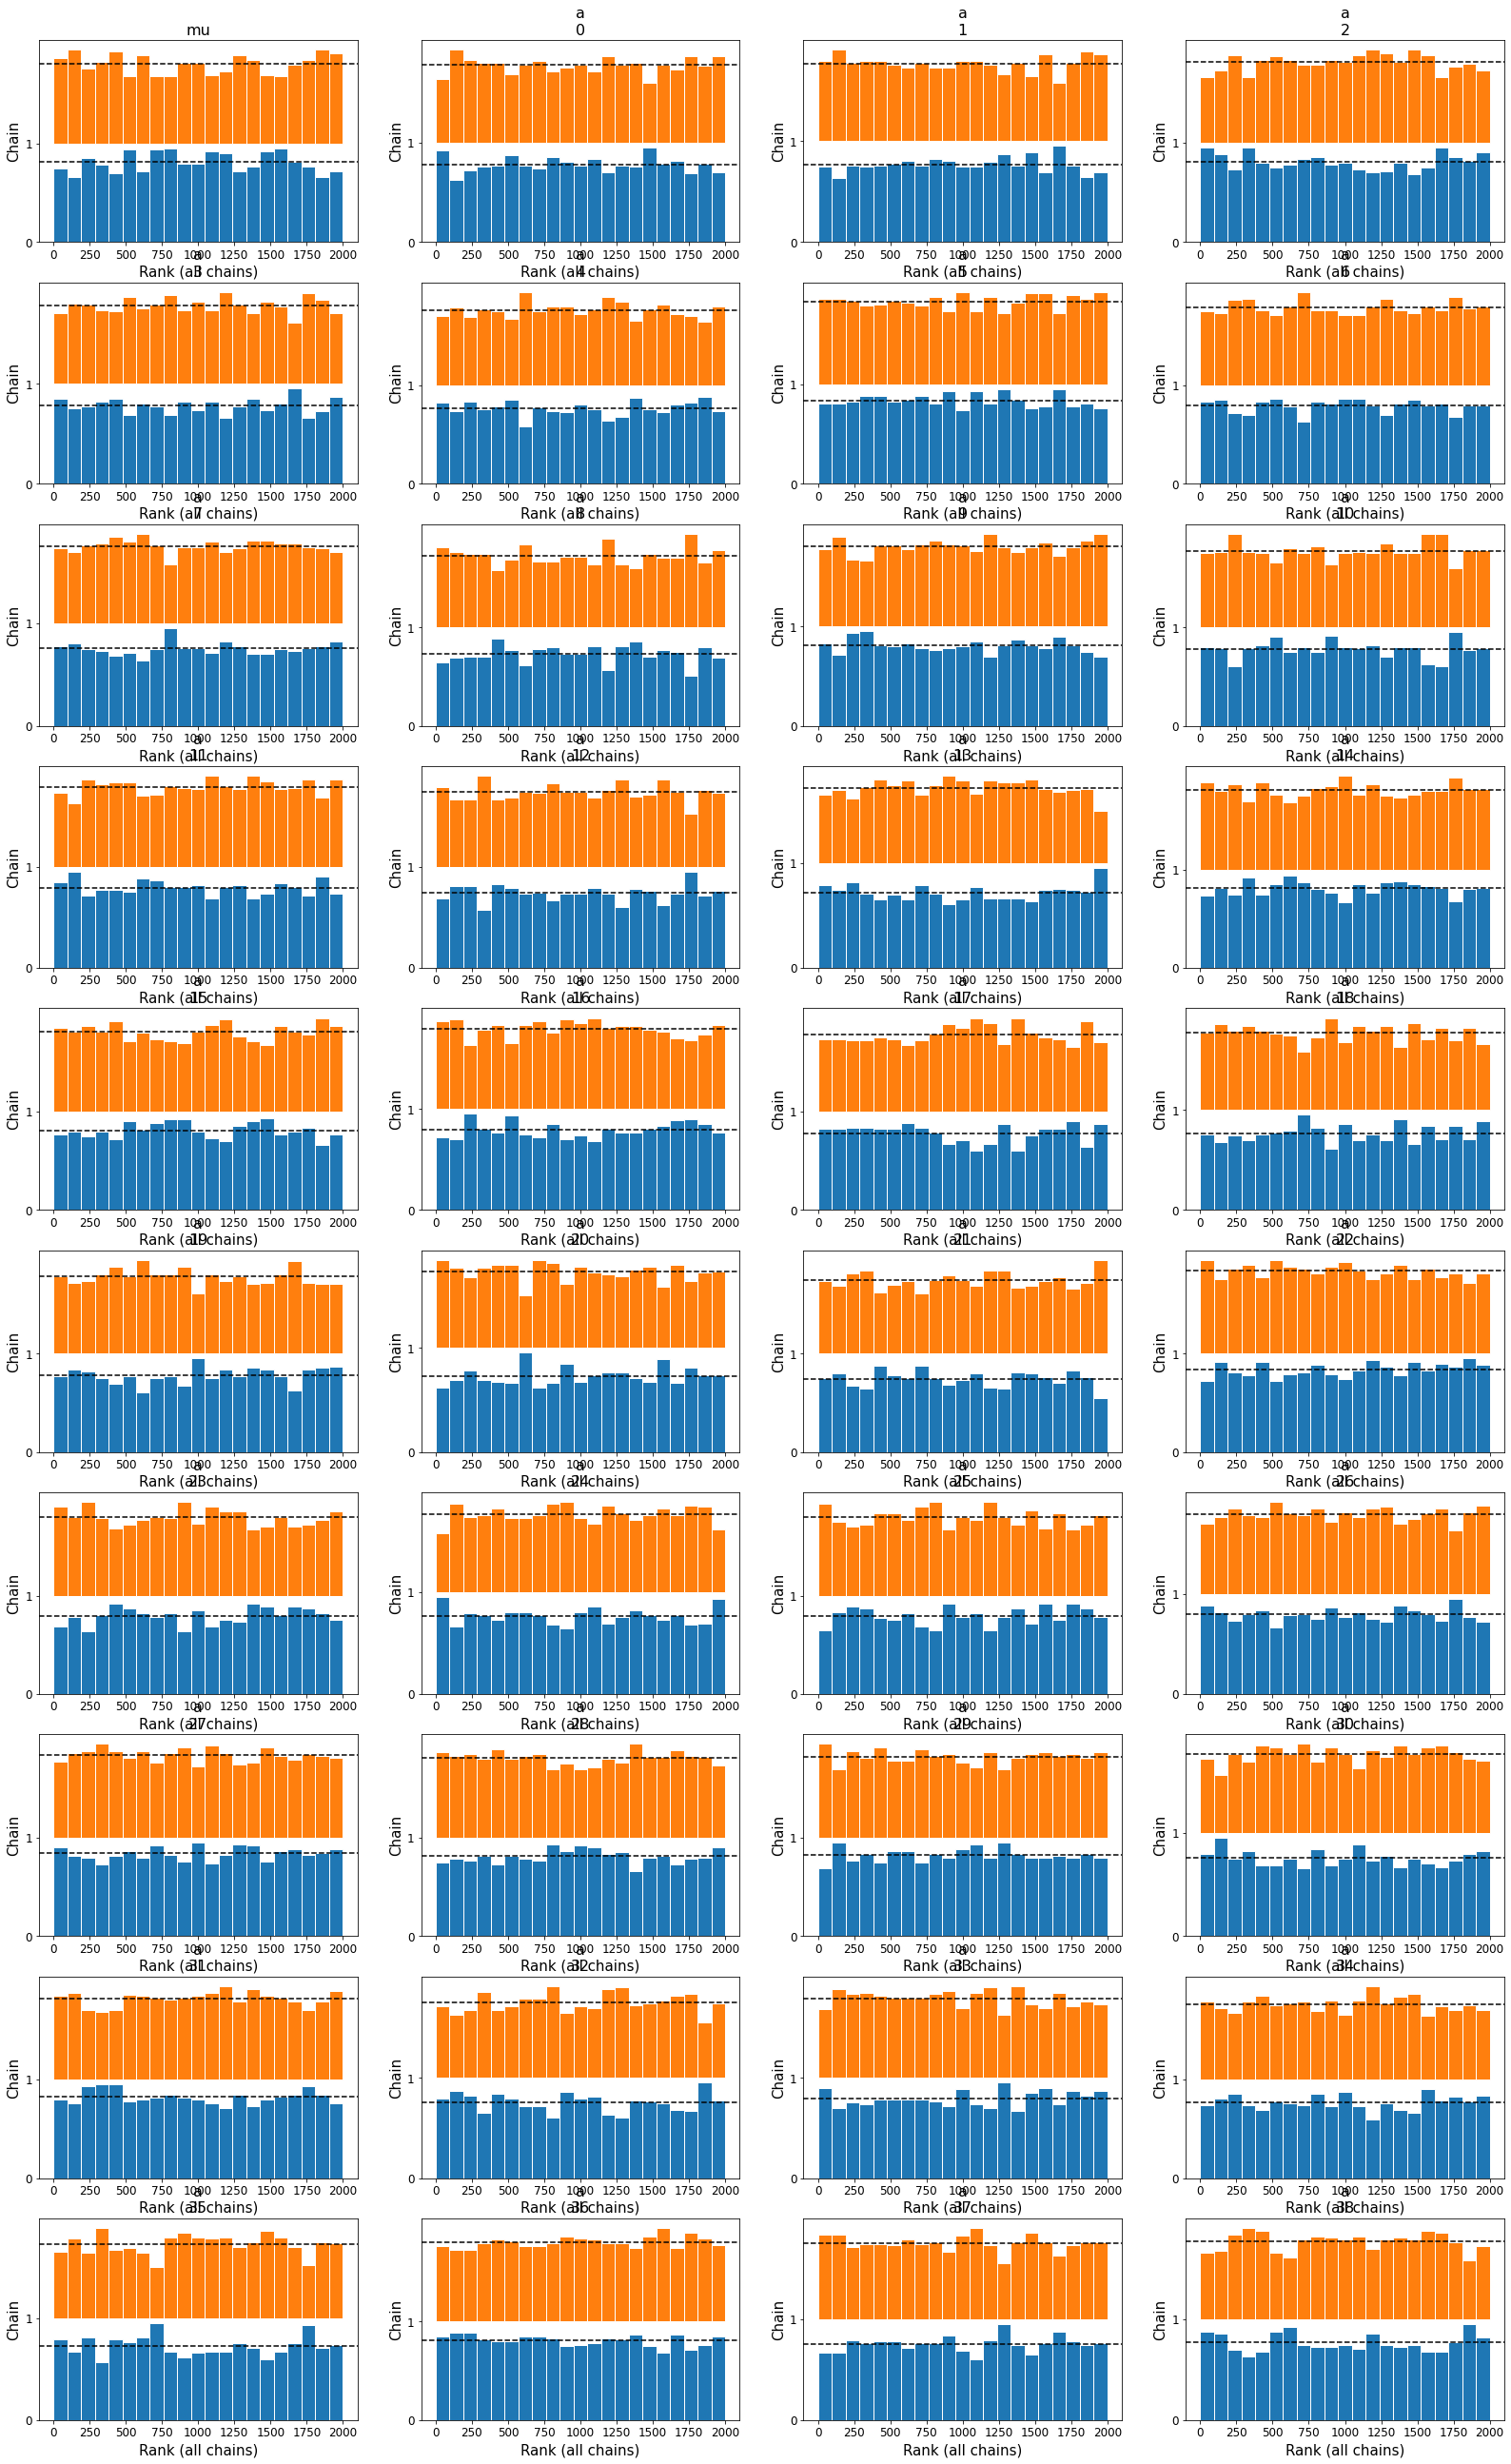

In [10]:
#partial pooling model 
with pm.Model() as model2:
    #prior
    mu=pm.Normal('mu',mu=5,sigma=0.7)
    sigma=pm.HalfNormal('sigma', sigma=0.7)
    a=pm.Normal('a',mu=mu, sigma=sigma, shape=len(data2))
    l=pm.Deterministic('l',pm.math.exp(a))

    #likelihood
    C=pm.Poisson('C', mu=l , observed = data2)

# Generate posterior samples
with model2:
    inference_partial= pm.sample(tune=3000,target_accept=0.99)
    display(az.summary(inference_partial))
    az.plot_rank(inference_partial)


We can see that the r_hat values are <=1.01, which means we have no reason to think that the sampler worked poorly. This value is supposed to indicate how well the sampler converges, with values below 1.01 implying it did so well. Looking at the effective sample size columns, we can see that they are more than 10% of the sample size, which also tells us the sampler probably worked well. Lastly, rank plots show us that the 2 chains are very similar and there are no skews in all parameters (uniformly distributed), which means the sampler explored all posterior and did not get stuck.

In [11]:
#generate prior predictive and posterior predictive samples
with model2: 
    inf_prior_pred2 = pm.sample_prior_predictive()
    inf_post_pred2 = pm.sample_posterior_predictive(inference_partial, extend_inferencedata=True)


In [12]:
inf_prior_pred2

Inference data with groups:
	> prior
	> prior_predictive
	> observed_data

In [13]:
inf_post_pred2

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

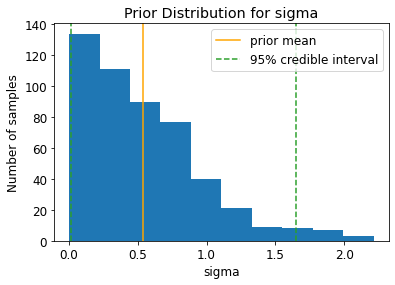

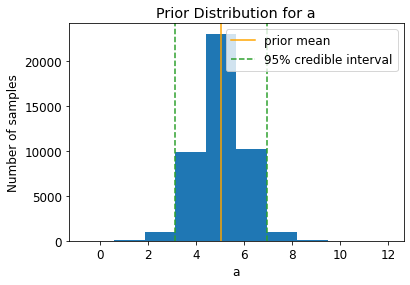

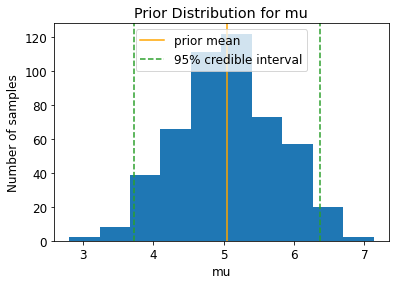

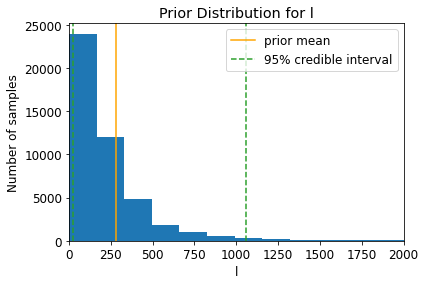

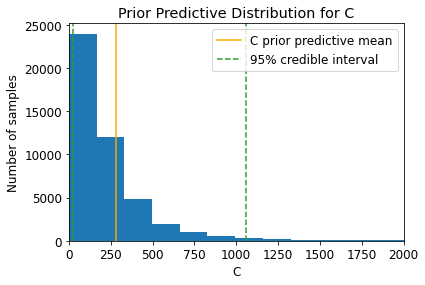

In [24]:
#priors for mu, sigma, a, and l with corresponding credible intervals and means
for i in inf_prior_pred2.prior:
    if i=='l':
        plt.xlim(0,2000)
        plt.hist(inf_prior_pred2.prior[i].values.flatten(), bins=1000)
    else:
        plt.hist(inf_prior_pred2.prior[i].values.flatten())
    plt.title('Prior Distribution for '+i)
    plt.xlabel(i)
    plt.ylabel('Number of samples')
    plt.axvline(np.mean(inf_prior_pred2.prior[i].values.flatten()), color='orange',label='prior mean')
    plt.axvline(np.quantile(inf_prior_pred2.prior[i].values.flatten(), 0.025), color='C2', linestyle='--',label='95% credible interval')
    plt.axvline(np.quantile(inf_prior_pred2.prior[i].values.flatten(), 0.975), color='C2', linestyle='--')
    plt.legend()
    plt.show()

#prior predictive C
plt.hist(inf_prior_pred2.prior_predictive.C.values.flatten(),bins=1000)
plt.title('Prior Predictive Distribution for C')
plt.xlabel('C')
plt.ylabel('Number of samples')
plt.axvline(np.mean(inf_prior_pred2.prior_predictive.C.values.flatten()), color='orange',label='C prior predictive mean')
plt.axvline(np.quantile(inf_prior_pred2.prior_predictive.C.values.flatten(), 0.025), color='C2', linestyle='--',label='95% credible interval')
plt.axvline(np.quantile(inf_prior_pred2.prior_predictive.C.values.flatten(), 0.975), color='C2', linestyle='--')
plt.legend()
plt.xlim(0,2000)
plt.show()


These prior and prior predictive distributions were used to tune the model so that it could generate reasonable range for parameters, hyperparameters, and consequently C (distribution of kelp plants in a grid square). We can see that mu and sigma hyperpriors generate a range of a values with 95% of which lying from 3 to 7. This, in turn, generates the range of lambda parameter with 95% lying from 0 to around 2000, but the clear majority lies before 800 and closer to 0. We can see that distribution for a is reasonable since e^7=1096.63 , and since 7 is the upper bound of a 95% credible interval, it produced values for lambda, and consequently C, in the reasonable range in agreement with our prior knowledge. Finally, the combination of all these priors leads to the reasonable prior predictive distribution of the number of kelp plants in each grid square (C) with the majority lying from 0 to 800, yet leaving the small possibility of higher numbers occuring. This makes our model reasonable.

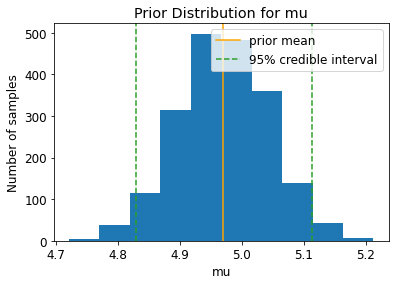

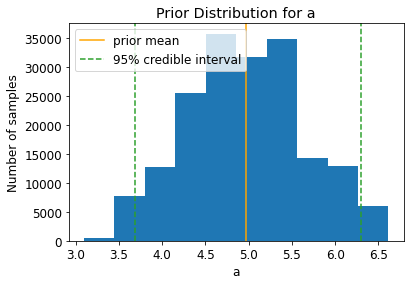

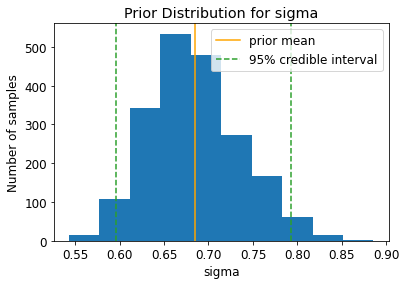

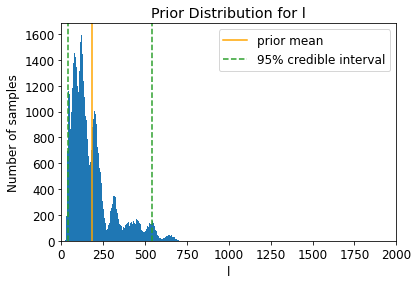

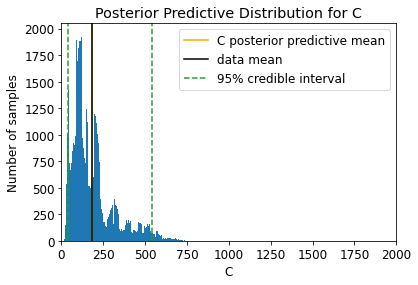

95% credible interval :  [40.000800816402666, 541.4863952052108]
Posterior predictive mean : 180.5085
Data mean : 180.52747252747253


In [28]:
#posteriors for mu, sigma, a, and l with corresponding credible intervals and means
for i in inf_post_pred2.posterior:
    if i=='l':
        plt.xlim(0,2000)
        plt.hist(inf_post_pred2.posterior[i].values.flatten(), bins=500)
    else:
        plt.hist(inf_post_pred2.posterior[i].values.flatten())
    plt.title('Posterior Distribution for '+i)
    plt.xlabel(i)
    plt.ylabel('Number of samples')
    plt.axvline(np.mean(inf_post_pred2.posterior[i].values.flatten()), color='orange',label='posterior mean')
    plt.axvline(np.quantile(inf_post_pred2.posterior[i].values.flatten(), 0.025), color='C2', linestyle='--',label='95% credible interval')
    plt.axvline(np.quantile(inf_post_pred2.posterior[i].values.flatten(), 0.975), color='C2', linestyle='--')
    plt.legend()
    plt.show()

#posterior predictive C
plt.hist(inf_post_pred2.posterior_predictive.C.values.flatten(),bins=500)
plt.title('Posterior Predictive Distribution for C')
plt.xlabel('C')
plt.ylabel('Number of samples')
plt.axvline(np.mean(inf_post_pred2.posterior_predictive.C.values.flatten()), color='orange',label='C posterior predictive mean')
plt.axvline(np.mean(data2), color='black',label='data mean')
plt.axvline(np.quantile(inf_post_pred2.posterior_predictive.C.values.flatten(), 0.025), color='C2', linestyle='--',label='95% credible interval')
plt.axvline(np.quantile(inf_post_pred2.posterior_predictive.C.values.flatten(), 0.975), color='C2', linestyle='--')
plt.legend()
plt.xlim(0,2000)
plt.show()

print('95% credible interval : ', [np.quantile(inf_post_pred2.posterior.l.values.flatten(), 0.025),np.quantile(inf_post_pred2.posterior.l.values.flatten(), 0.975)])
print('Posterior predictive mean :', np.mean(inf_post_pred2.posterior_predictive.C.values.flatten()))
print('Data mean :', np.mean(data2))

Looking at the posterior and posterior predictive distributions we see how the model predicted the distribution of parameters after taking data into account. We can see that the ranges for lambda parameter and for C variable are reasonable since most of the density (95% credible interval) lies below 540. We can also see that the data mean and posterior mean are very similar, which might indicate that the model learned well from the data. However, it does not tell us anything about the model's predictive power. Also, the cumulative posterior for the lambda parameter does not give us an insight into the each individual grid square. Thus, we can further look into the posterior distributions for each individual lambda parameter.

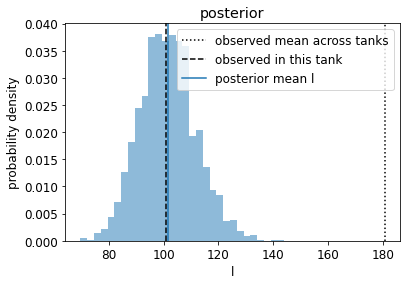

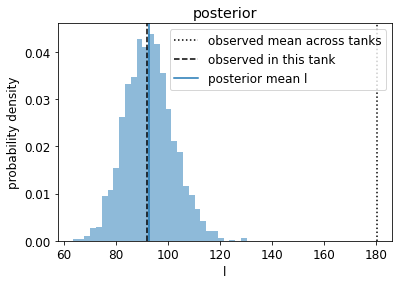

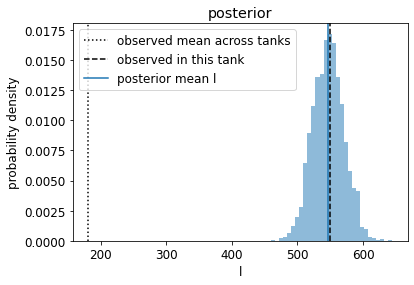

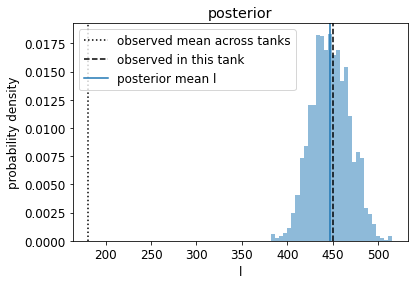

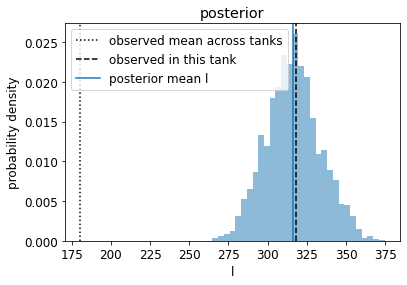

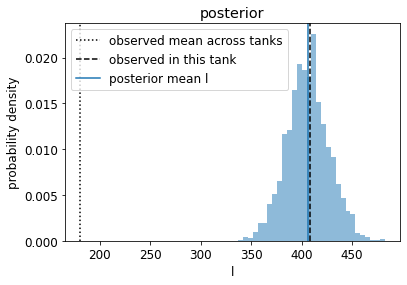

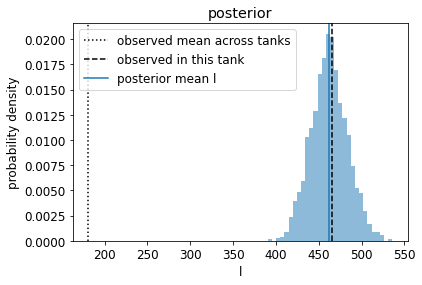

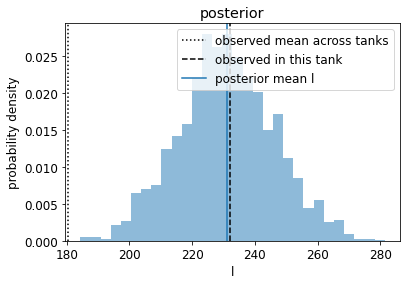

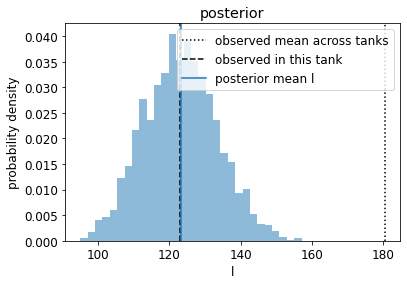

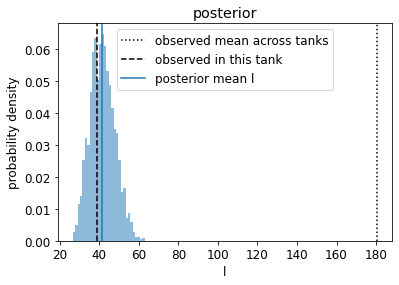

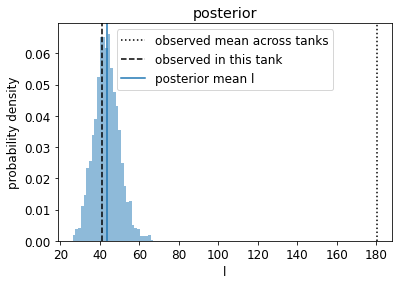

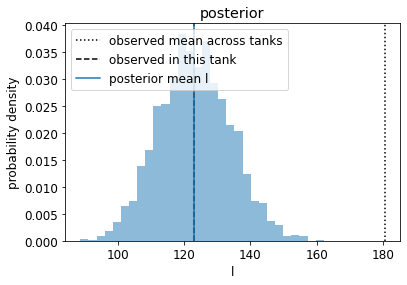

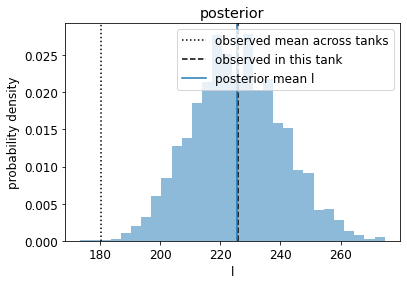

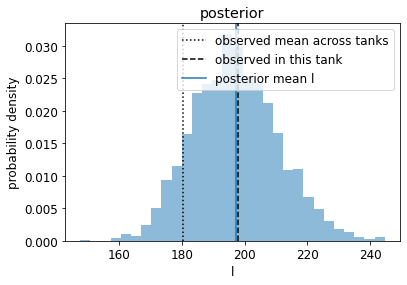

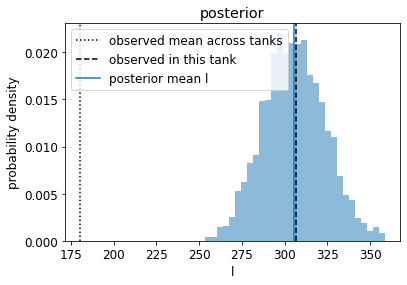

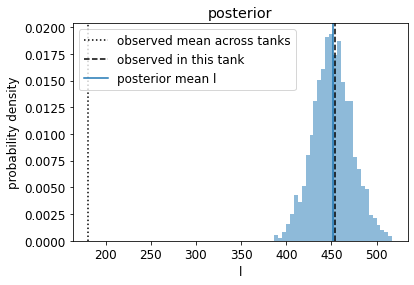

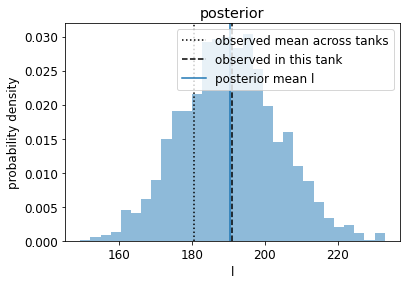

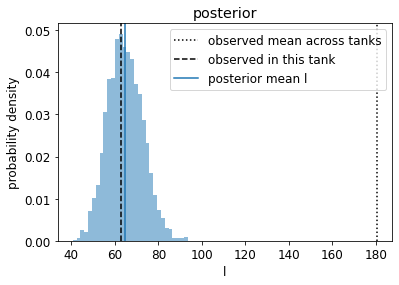

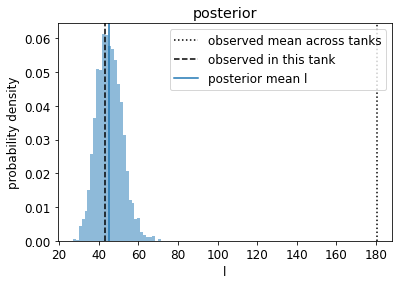

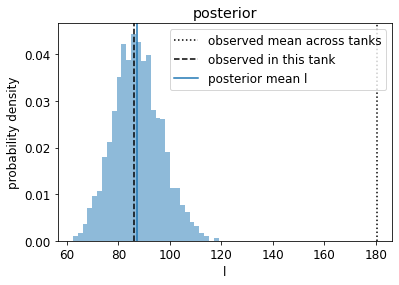

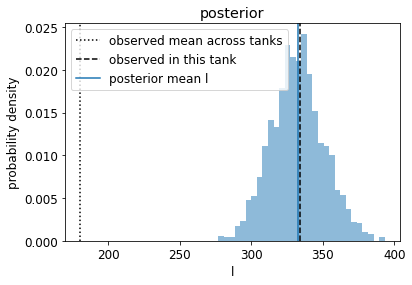

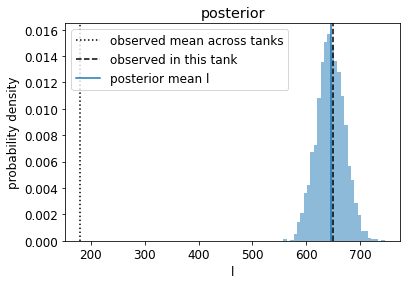

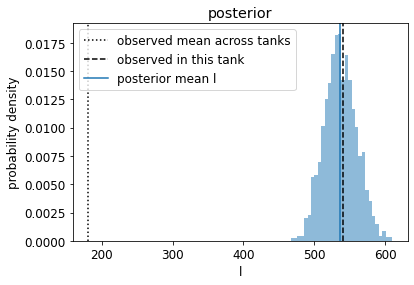

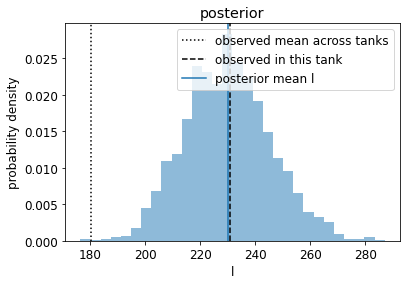

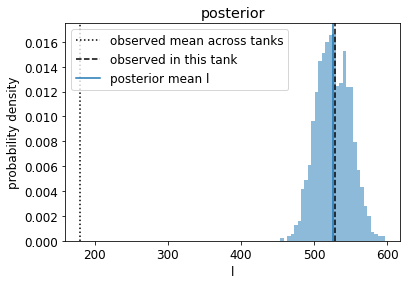

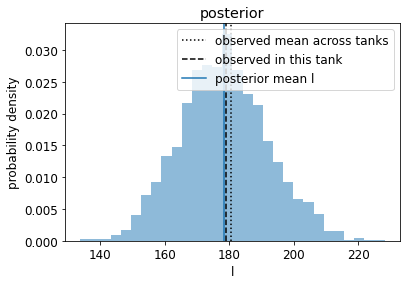

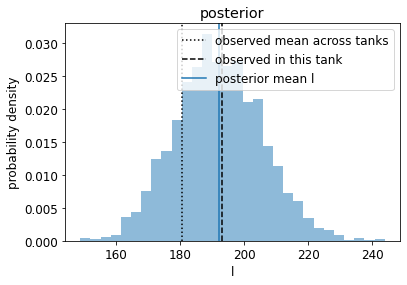

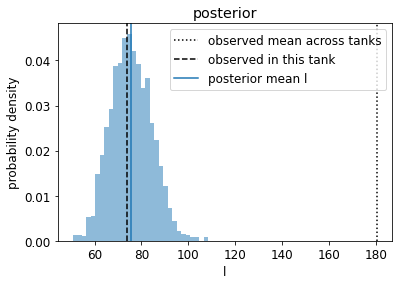

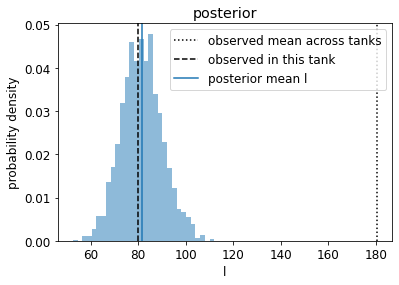

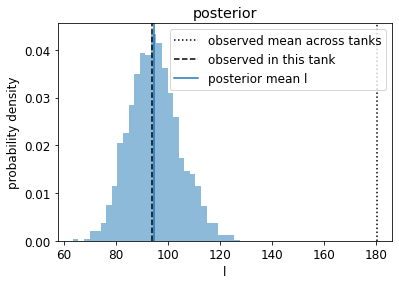

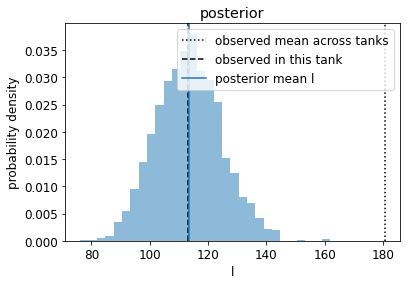

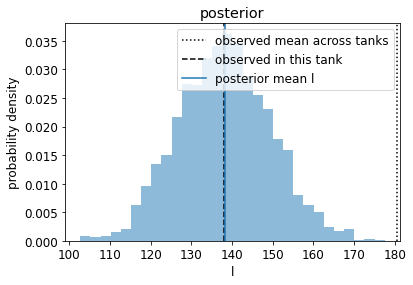

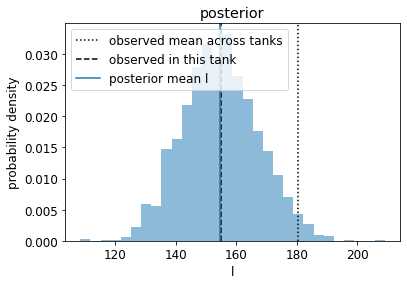

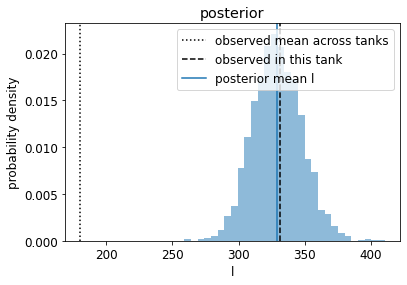

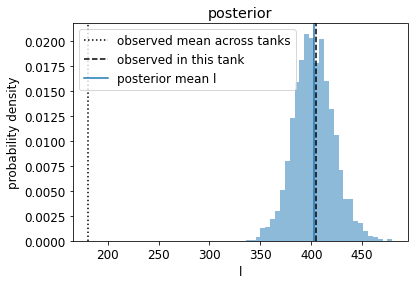

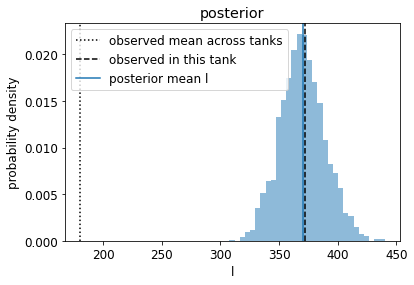

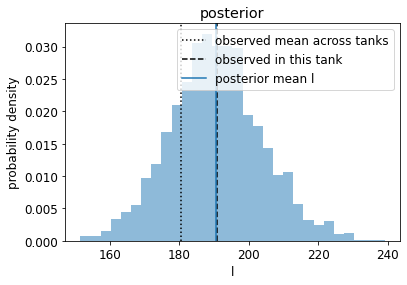

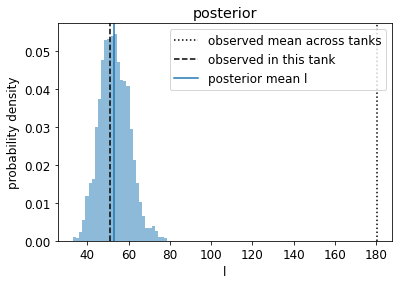

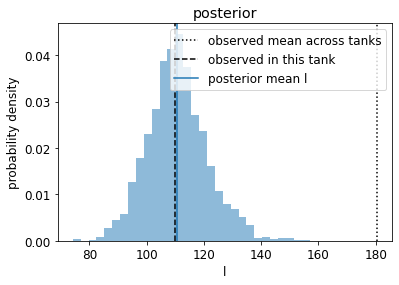

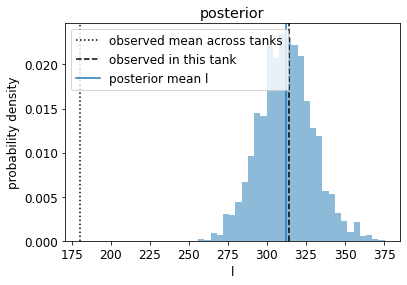

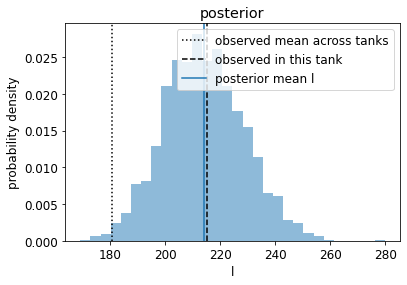

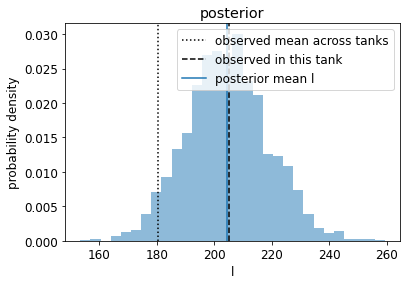

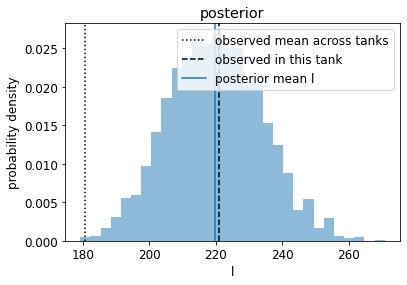

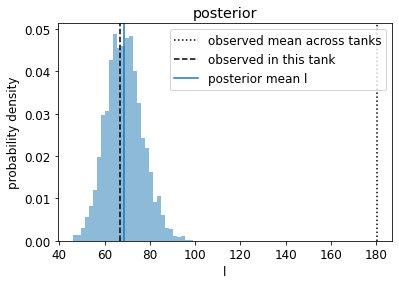

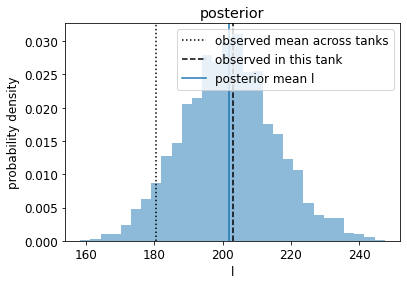

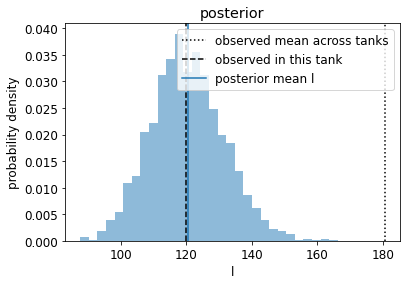

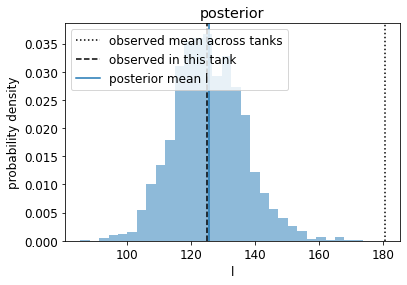

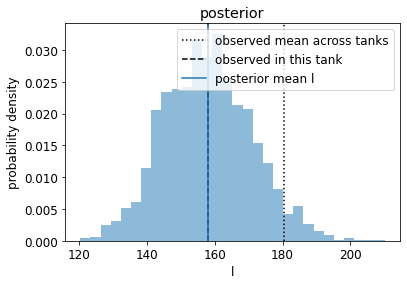

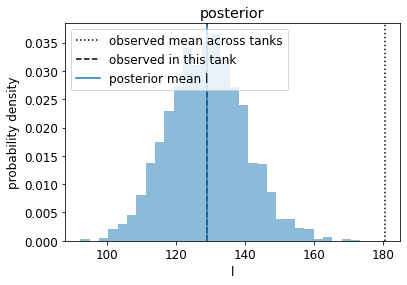

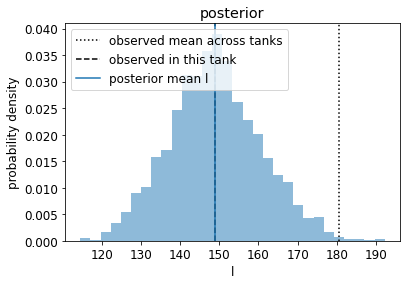

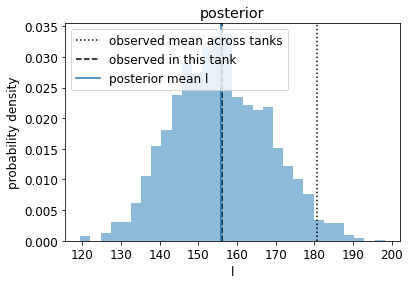

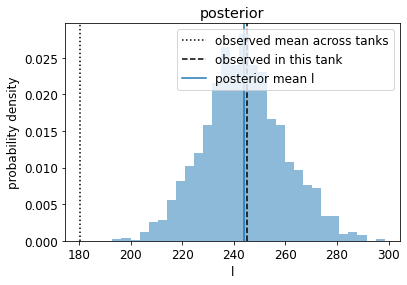

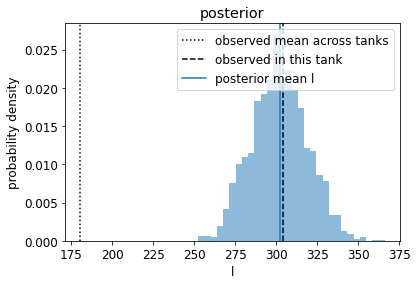

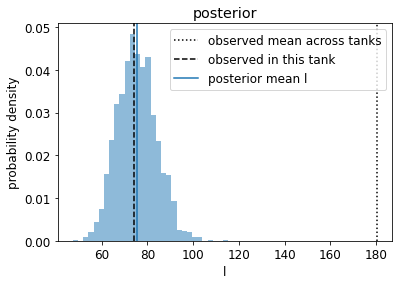

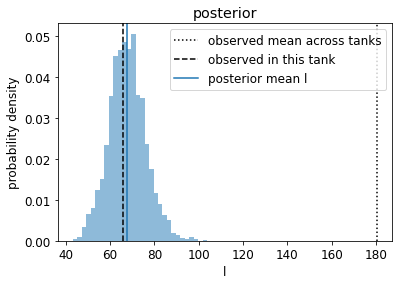

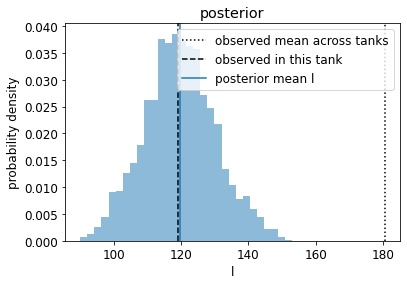

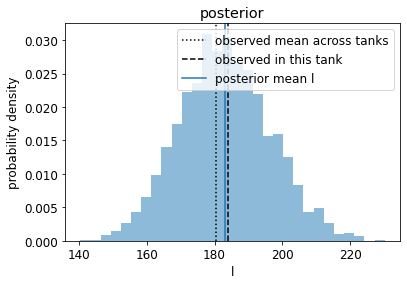

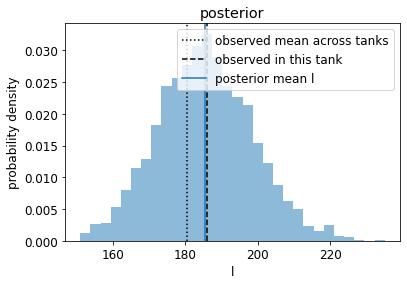

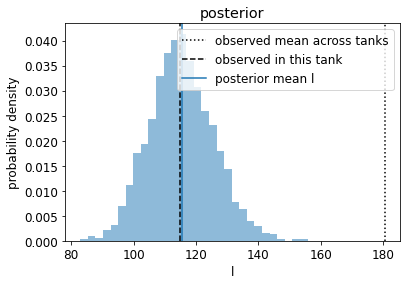

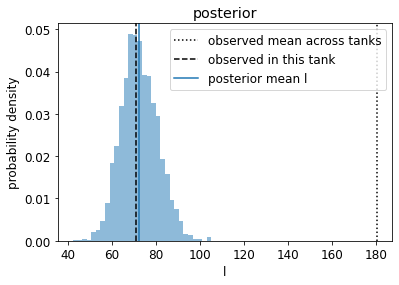

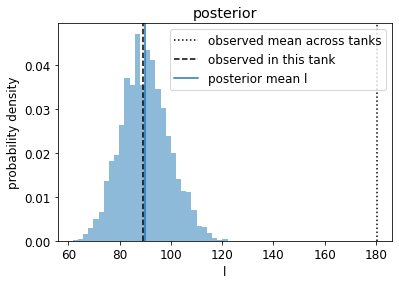

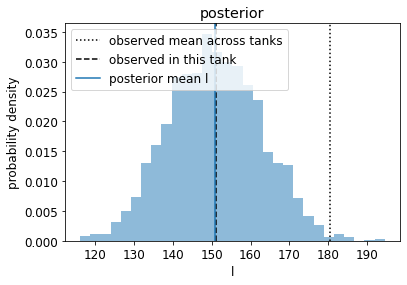

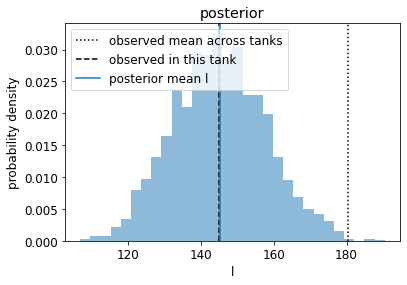

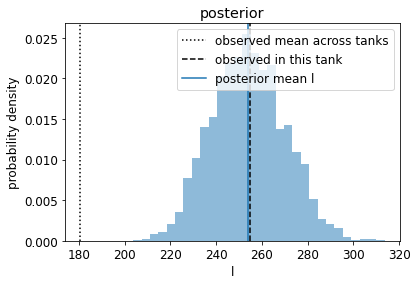

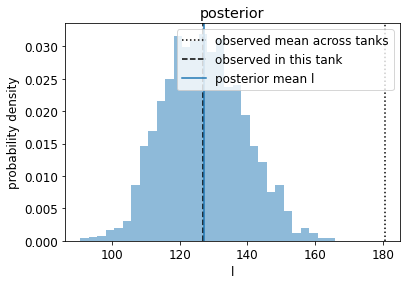

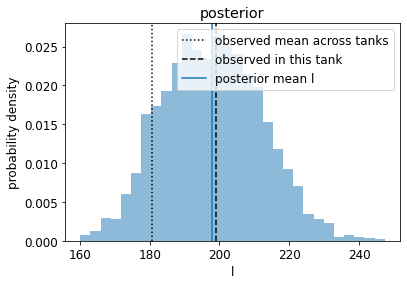

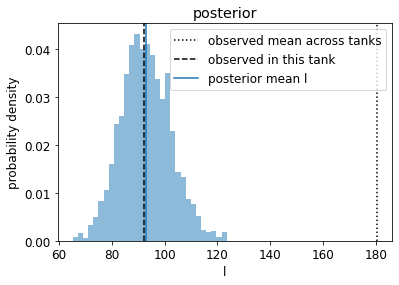

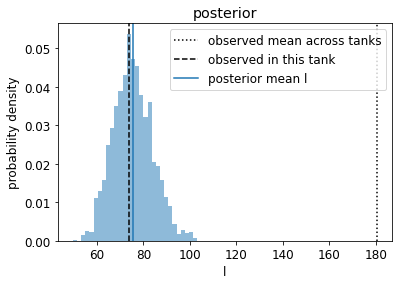

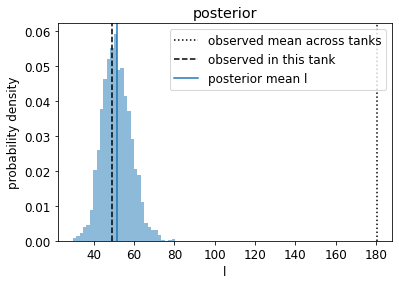

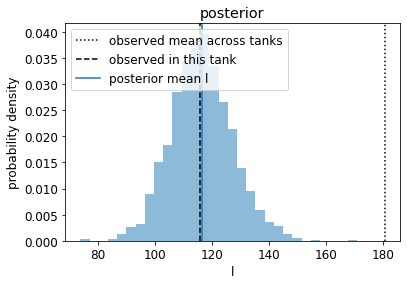

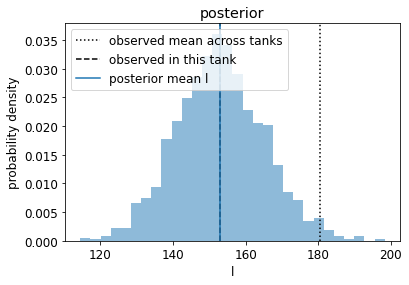

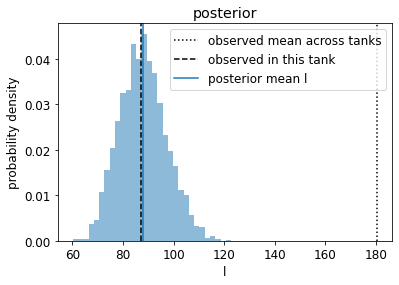

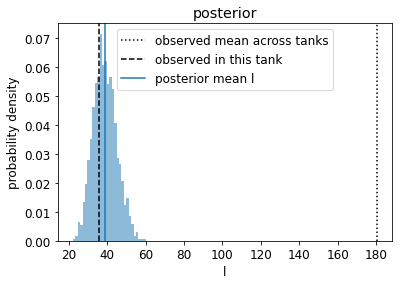

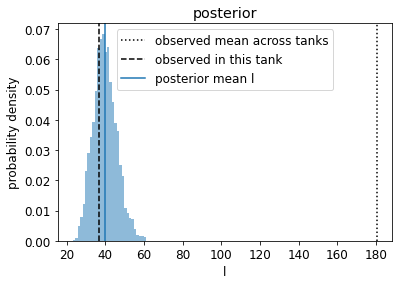

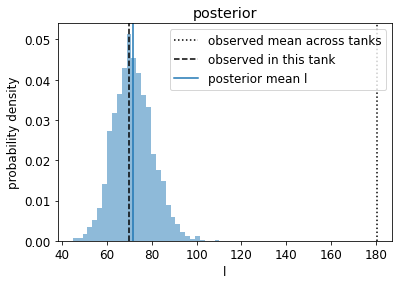

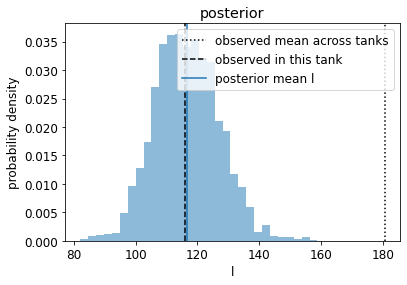

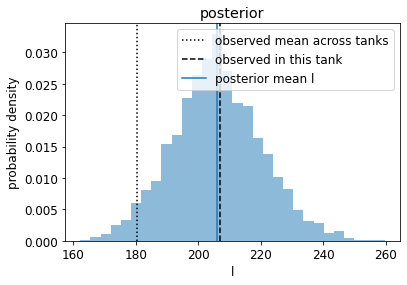

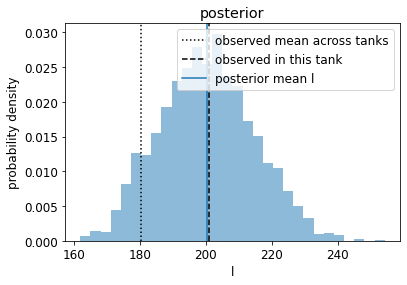

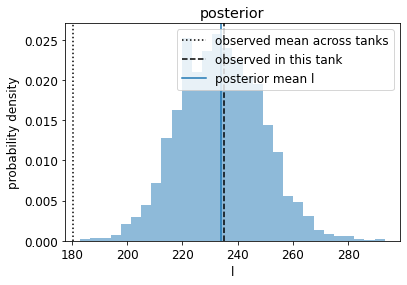

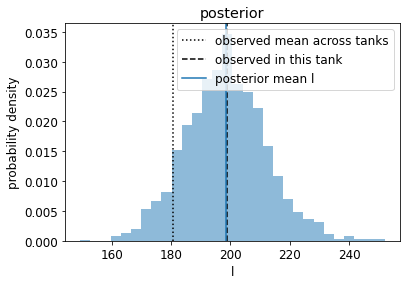

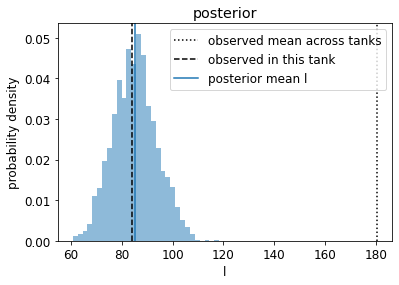

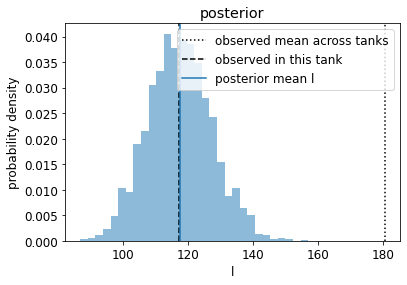

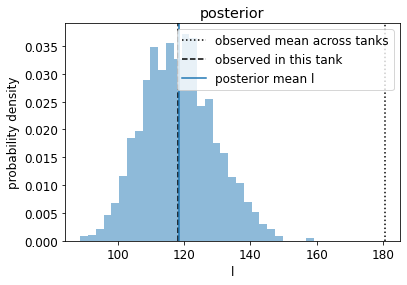

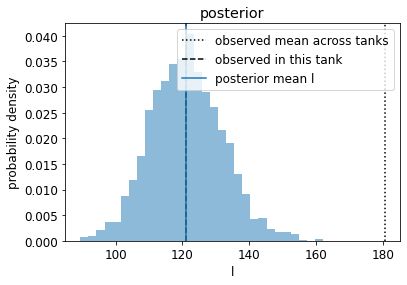

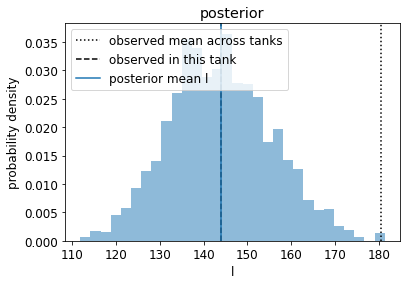

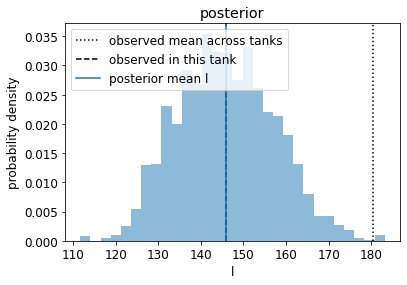

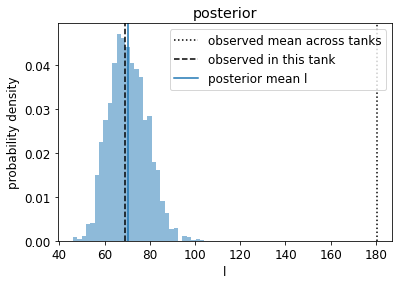

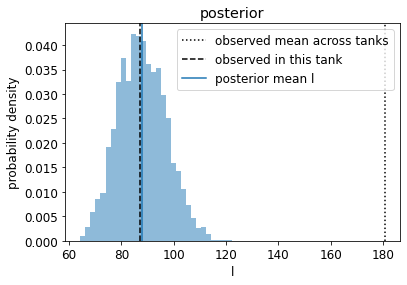

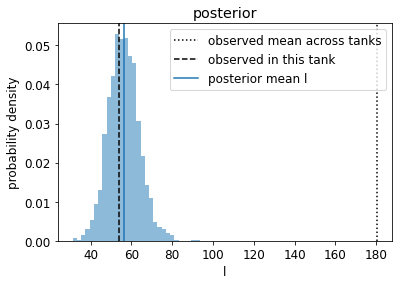

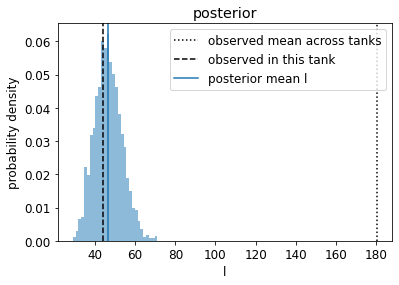

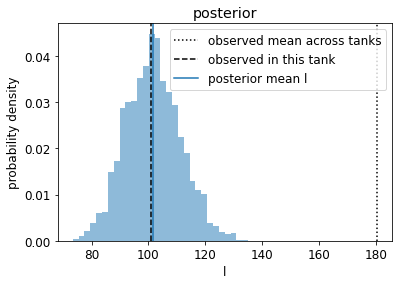

In [29]:
#posteriors for each l
for i in range(91):
    plt.figure()
    plt.title('posterior')
    plt.hist(
            inf_post_pred2.posterior.l[:, :, i].values.flatten(), bins=30,
            density=True, alpha=0.5)
    plt.axvline(np.mean(data2), color='black', linestyle=':', label='observed mean across grid squares')
    plt.axvline(data2[i], color='black', linestyle='--', label='observed in this grid square')
    plt.axvline(np.mean(inf_post_pred2.posterior.l[:, :, i].values.flatten()), color='C0', linestyle='-', label='posterior mean l')
    plt.xlabel('l')
    plt.ylabel('probability density')
    plt.legend()
    plt.show()

On the posterior plots above we can see the mean for a specific grid square, the mean across all squares, as well as the mean of the grid square according to the model. We can note that the posterior mean shifts a little bit towards the mean across all tanks. This phenomenon is called shrinkage. It arises due to the partial pooling model's tendency to balance between over and under fitting. Although the squares are somewhat independent, the model estimates the parameters for each square by incorporating the information it learned from previous squares. This effect shifts the posterior mean away from the true mean for the square and towards the mean across all squares. The shrinkage effect is stronger when there is less data in a given square, thus there is more uncertainty (narrower distribution) and the effect of the pooled information from other grid squares is higher. This way, grid squares with fewer kelp plants that are more prone to overfitting need more 'correction' by the underfit mean across all squares. Larger squares, on the other hand, are less subject to overfitting and are influenced less.

# Predictions

**Complete pooling**

Mean: 180.3825
95% credible interval :  [154.0, 206.0]


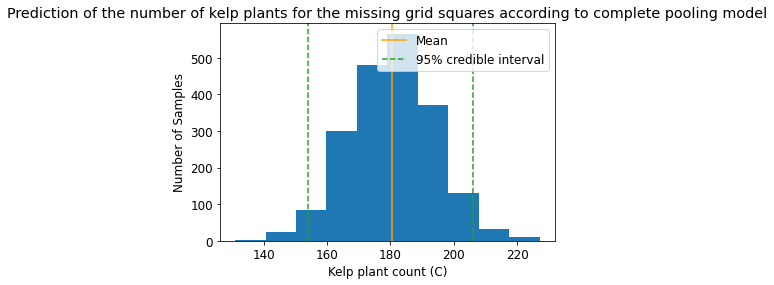

In [30]:
#predictions for new squares using complete pooling model
c=sts.poisson.rvs(mu=inference_complete.posterior.l_trans.values.flatten())

plt.figure()
plt.title('Prediction of the number of kelp plants for the missing grid squares according to complete pooling model')
plt.hist(c)
plt.axvline(np.mean(c), color='orange',label='Mean')
plt.axvline(np.quantile(c, 0.025), color='C2', linestyle='--',label='95% credible interval')
plt.axvline(np.quantile(c, 0.975), color='C2', linestyle='--')
plt.xlabel('Kelp plant count (C)')
plt.ylabel('Number of Samples')
plt.legend()
print('Mean:',np.mean(c))
print('95% credible interval : ', [np.quantile(c, 0.025),np.quantile(c, 0.975)])

Here we can see a distribution of the counts of kelp plants predicted for a new grid square using a complete pooling model. To achieve this, we generated a radom variable c (for the kelp count) from a poisson distribution, which was the likelihood of the model, with the rate parameter of lambda taken from the posterior distribution of the complete pooling model. Looking at the mean and the 95% credible interval, we can see that the model is very certain in its prediction since the distribution is so narrow. The reason for such behavior is that the model assumes all grid squares are the same, thus there would be very little variation in the number of kelp across squares. We can confirm that by seeing that the predicted mean is very close to the data mean across all squares.

**Partial Pooling**

Mean: 185.0015
95% credible interval :  [37.0, 585.0249999999999]


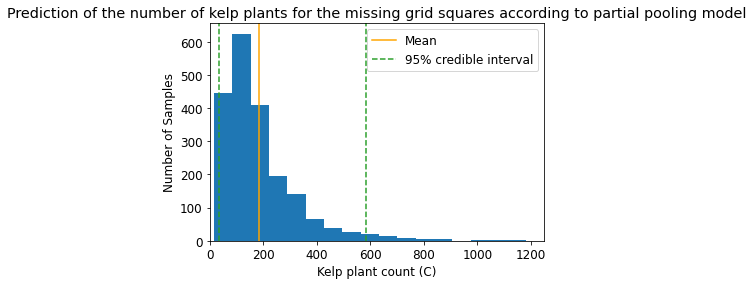

In [31]:
#predictions for new squares using partial pooling model

a = sts.norm.rvs(
    loc=inf_post_pred2.posterior.mu.values.flatten(),
    scale=inf_post_pred2.posterior.sigma.values.flatten())
l=np.exp(a)
c_part=sts.poisson.rvs(mu=l)


plt.title('Prediction of the number of kelp plants for the missing grid squares according to partial pooling model')
plt.hist(c_part,bins=30)
plt.axvline(np.mean(c_part), color='orange',label='Mean')
plt.axvline(np.quantile(c_part, 0.025), color='C2', linestyle='--',label='95% credible interval')
plt.axvline(np.quantile(c_part, 0.975), color='C2', linestyle='--')
plt.xlabel('Kelp plant count (C)')
plt.ylabel('Number of Samples')
plt.xlim(0,1250)
plt.legend()

print('Mean:', np.mean(c_part))
print('95% credible interval : ', [np.quantile(c_part, 0.025),np.quantile(c_part, 0.975)])

Here we can see a distribution of the counts of kelp plants predicted for a new grid square using a partial pooling model. To achieve this, we first generated a radom variable a from a normal distribution, which was one of the priors of the model, using the model's posteriors for hyperparameters mu and sigma as parameters for this normal distribution. We further transformed the a variable into the correct scale by exponentiating it (obtained lambda parameter). Finally, we used this lambda as a rate prameter for a poisson distribution, from which we randomly generated c variable (for kelp count). Looking at the mean and the 95% credible interval, we can see that the model is very uncertain in its prediction since the distribution is so wide. The reason for such behavior is that the model grid squares differ from each other, thus there would be very more variation in the number of kelp across squares. At the same time, the model tries to inform the predictions for new squares using the information from previous known squares. 

If we compare the predictions of the 2 models, we see that complete pooling model is much more certain than the partial pooling model. That, however, does not mean the complete pooling model is better. It might be very certain, but still very wrong. In our context, the partial pooling model seems to make more sense because it incorporates the variation in the actual data in its predictions better. Complete pooling simply thinks all squares are the same, predicting minimal variation between them, which we know is not accurate given the data we have and the prior knowledge that the number of kelp per square is around 0-800 plants. Partial pooling takes this into account and tries to adjust its predictions for each square, leading to higher variation and less certainty in its predictions but a more accurate representation of reality.